In [1]:
import numpy as np
import scipy as sp
import pandas as pd
from time import time

import warnings
warnings.filterwarnings('ignore')
from IPython.core.display import HTML, display

import matplotlib.pylab as plt
import matplotlib.cm as cm

import cv2

%matplotlib inline

import keras as ks
import tensorflow as tf
from keras.models import Sequential, load_model, Model
from keras.preprocessing.image import ImageDataGenerator
from keras.optimizers import SGD, RMSprop
from keras.layers import Dense, Dropout, LSTM, ConvLSTM2D, Reshape
from keras.layers import Activation, Flatten, Input, BatchNormalization
from keras.layers import Conv1D, MaxPooling1D, Conv2D, MaxPooling2D
from keras.layers import AveragePooling2D, GlobalMaxPooling2D, GlobalAveragePooling2D
from keras.layers.embeddings import Embedding
from keras.layers.advanced_activations import PReLU, LeakyReLU
from keras.callbacks import ModelCheckpoint
from keras.callbacks import EarlyStopping, ReduceLROnPlateau
from keras.applications.inception_v3 import InceptionV3 
from keras.applications.vgg16 import VGG16 
from keras.applications.vgg19 import VGG19


from sklearn.neural_network import MLPClassifier
from sklearn import linear_model, neighbors, svm, ensemble
from sklearn import datasets, metrics 
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import VarianceThreshold, SelectKBest, chi2
from sklearn.decomposition import PCA

from skimage import transform


from keras import __version__
print('keras version:', __version__)
print('tensorflow version:', tf.__version__)

Using TensorFlow backend.


keras version: 2.2.4
tensorflow version: 1.12.0


In [2]:
df_train = pd.read_csv("train.csv")
df_test = pd.read_csv("test.csv")
df_train.shape

(42000, 785)

In [3]:
df_train.ix[15:20,15:20]

,pixel14,pixel15,pixel16,pixel17,pixel18
15,0,0,0,0,0
16,0,0,0,0,0
17,0,0,0,0,0
18,0,0,0,0,0
19,0,0,0,0,0
20,0,0,0,0,0


In [4]:
images = ["%s%s" %("pixel",pixel_no) for pixel_no in range(0,784)]
train_images = np.array(df_train[images])
train_images = train_images.astype('float32')/255
train_images.shape

(42000, 784)

In [5]:
train_labels = df_train['label']
train_labels_cat = ks.utils.to_categorical(train_labels, num_classes=10)
train_labels_cat.shape

(42000, 10)

In [6]:
test_images = np.array(df_test[images])
test_images = test_images.astype('float32')/255
test_images.shape

(28000, 784)

In [7]:
#Preprocessing

def find_borders(x):
    left, right, top, bottom = [], [], [], []
    
    for k in range(x.shape[0]):
        
        for j in range(28):
            for i in range(28):
                if (x[k,28*i+j] >= 0.4):
                    left.append(j)
                    break
            if (len(left) > k):
                break
                
        for j in range(28):
            for i in range(28):
                if (x[k, 28*i+(28-1-j)] >= 0.4):
                    right.append(28-1-j)
                    break
            if (len(right) > k):
                break 
                
        for i in range(28):
            for j in range(28):
                if (x[k,28*i+j] >= 0.4):
                    top.append(i)
                    break
            if (len(top) > k):
                break 
                
        for i in range(28):
            for j in range(28):
                if (x[k,28*(28-1-i)+j] >= 0.4):
                    bottom.append(28-1-i)
                    break
            if (len(bottom) > k):
                break       
        
    return left, right, top, bottom

In [8]:
def resize_images(x):
    left, right, top, bottom = find_borders(x)    
    x = x.reshape(-1,28,28)
    
    for i in range(x.shape[0]):      
        x[i] = transform.resize(x[i][top[i]:bottom[i]+1,left[i]:right[i]+1],(28,28))
#        x[i] = transform.resize(x[i][top[i]:bottom[i]+1,left[i]:right[i]+1],(24,24))    
    return(x.reshape(-1,28**2))
#    return(x.reshape(-1,24**2))

In [9]:
def variance_threshold(train, test):
    selector = VarianceThreshold(threshold=0).fit(train)
    train = selector.transform(train)
    test = selector.transform(test)
    return train, test

In [10]:
def select_kbest(train, train_categories, test):
    selector = SelectKBest(chi2, k=512).fit(train, train_categories)
    train = selector.transform(train)
    test = selector.transform(test)
    return train, test

In [11]:
def pca(train, test):
    pca = PCA(n_components=0.95)
    pca.fit(train)
    train = pca.transform(train)
    test = pca.transform(test)
    return train, test

In [12]:
X_train, X_test, y_train, y_test = train_test_split(train_images, train_labels_cat, 
                                                    test_size=0.2, random_state=32)

In [13]:
n = int(len(X_test)/2)
X_valid, y_valid = X_test[:n], y_test[:n]
X_test, y_test = X_test[n:], y_test[n:]
X_train.shape, X_test.shape, X_valid.shape, y_train.shape, y_test.shape, y_valid.shape

((33600, 784), (4200, 784), (4200, 784), (33600, 10), (4200, 10), (4200, 10))

In [14]:
y_train_num = np.array([np.argmax(x) for x in y_train])
y_test_num = np.array([np.argmax(x) for x in y_test])
y_valid_num = np.array([np.argmax(x) for x in y_valid])

In [15]:
X_train_app = [cv2.cvtColor(cv2.resize(i, (32,32)), cv2.COLOR_GRAY2BGR) for i in X_train]
X_train_app = np.concatenate([arr[np.newaxis] for arr in X_train_app]).astype('float32')

X_test_app = [cv2.cvtColor(cv2.resize(i, (32,32)), cv2.COLOR_GRAY2BGR) for i in X_test]
X_test_app = np.concatenate([arr[np.newaxis] for arr in X_test_app]).astype('float32')

X_valid_app = [cv2.cvtColor(cv2.resize(i, (32,32)), cv2.COLOR_GRAY2BGR) for i in X_valid]
X_valid_app = np.concatenate([arr[np.newaxis] for arr in X_valid_app]).astype('float32')

In [16]:
X_train_app.shape, X_test_app.shape, X_valid_app.shape, y_train.shape, y_test.shape, y_valid.shape

((33600, 32, 32, 3),
 (4200, 32, 32, 3),
 (4200, 32, 32, 3),
 (33600, 10),
 (4200, 10),
 (4200, 10))

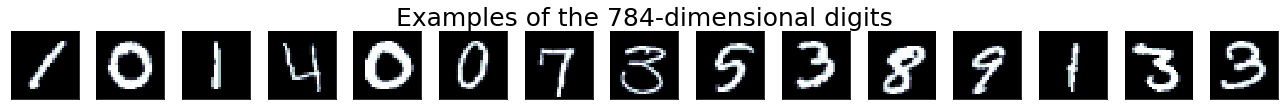

In [17]:
#Visualize

fig, ax = plt.subplots(figsize=(18, 2), nrows=1, ncols=15, sharex=True, sharey=True,)
ax = ax.flatten()

for i in range(15):
    image = train_images[i].reshape(28,28)
    ax[i].imshow(image, cmap=cm.bone)

ax[0].set_xticks([])
ax[0].set_yticks([])
plt.tight_layout()
plt.gcf()
ax[7].set_title('Examples of the 784-dimensional digits', fontsize=25);

In [18]:
X_train_tensor = tf.image.grayscale_to_rgb(X_train.reshape(-1, 28, 28, 1), name=None)
X_test_tensor = tf.image.grayscale_to_rgb(X_test.reshape(-1, 28, 28, 1), name=None)
X_valid_tensor = tf.image.grayscale_to_rgb(X_valid.reshape(-1, 28, 28, 1), name=None)

In [19]:
sess = tf.Session()
with sess.as_default():
    X_train_color = X_train_tensor.eval()
    X_test_color = X_test_tensor.eval()
    X_valid_color = X_valid_tensor.eval()

In [20]:
X_train_color.shape, X_test_color.shape, X_valid_color.shape

((33600, 28, 28, 3), (4200, 28, 28, 3), (4200, 28, 28, 3))

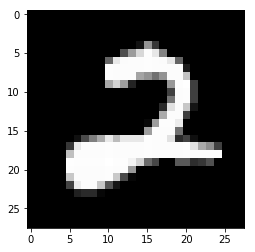

In [21]:
plt.imshow(X_test_color[0]);

In [22]:
#CNN_Models

def cnn_mc_model():
    model_input = Input(shape=(28, 28, 1))
    x = BatchNormalization()(model_input)
    
    x = Conv2D(28, (5, 5), padding='same')(x)
    x = LeakyReLU(alpha=0.02)(x)
    x = MaxPooling2D(pool_size=(2, 2))(x)
    x = Dropout(0.25)(x)
    
    x = Conv2D(128, (5, 5))(x)
    x = LeakyReLU(alpha=0.02)(x)
    x = MaxPooling2D(strides=(2, 2))(x)
    x = Dropout(0.25)(x)   

    x = GlobalMaxPooling2D()(x)
    
    x = Dense(1024)(x)
    x = LeakyReLU(alpha=0.02)(x)
    x = Dropout(0.5)(x)
    
#    x = Reshape((1, 128), input_shape=(128,))(x)
#    x = LSTM(128, activation='relu')(x)
    
    y = Dense(10, activation='softmax')(x)
    
    model = Model(input=model_input, output=y)
    model.compile(loss='categorical_crossentropy', optimizer='nadam', metrics=['accuracy'])
    
    return model

cnn_mc_model = cnn_mc_model()

In [23]:
cnn_checkpointer = ModelCheckpoint(filepath='weights.best3.cnn_mc.digits.hdf5', 
                                   verbose=2, save_best_only=True)
cnn_lr_reduction = ReduceLROnPlateau(monitor='val_acc', 
                                     patience=5, verbose=2, 
                                     factor=0.5, min_lr=0.000001)

fit_cnn = cnn_mc_model.fit(X_train.reshape(-1, 28, 28, 1), y_train, 
                           validation_data=(X_valid.reshape(-1, 28, 28, 1), y_valid), 
                           epochs=50, batch_size=128, verbose=2, 
                           callbacks=[cnn_checkpointer, cnn_lr_reduction])

Train on 33600 samples, validate on 4200 samples
Epoch 1/50
 - 58s - loss: 0.4350 - acc: 0.8590 - val_loss: 0.0879 - val_acc: 0.9748

Epoch 00001: val_loss improved from inf to 0.08785, saving model to weights.best3.cnn_mc.digits.hdf5
Epoch 2/50
 - 26s - loss: 0.0914 - acc: 0.9716 - val_loss: 0.0555 - val_acc: 0.9848

Epoch 00002: val_loss improved from 0.08785 to 0.05547, saving model to weights.best3.cnn_mc.digits.hdf5
Epoch 3/50
 - 27s - loss: 0.0721 - acc: 0.9773 - val_loss: 0.0473 - val_acc: 0.9874

Epoch 00003: val_loss improved from 0.05547 to 0.04726, saving model to weights.best3.cnn_mc.digits.hdf5
Epoch 4/50
 - 27s - loss: 0.0615 - acc: 0.9812 - val_loss: 0.0480 - val_acc: 0.9867

Epoch 00004: val_loss did not improve from 0.04726
Epoch 5/50
 - 27s - loss: 0.0530 - acc: 0.9837 - val_loss: 0.0396 - val_acc: 0.9883

Epoch 00005: val_loss improved from 0.04726 to 0.03961, saving model to weights.best3.cnn_mc.digits.hdf5
Epoch 6/50
 - 28s - loss: 0.0513 - acc: 0.9831 - val_loss: 

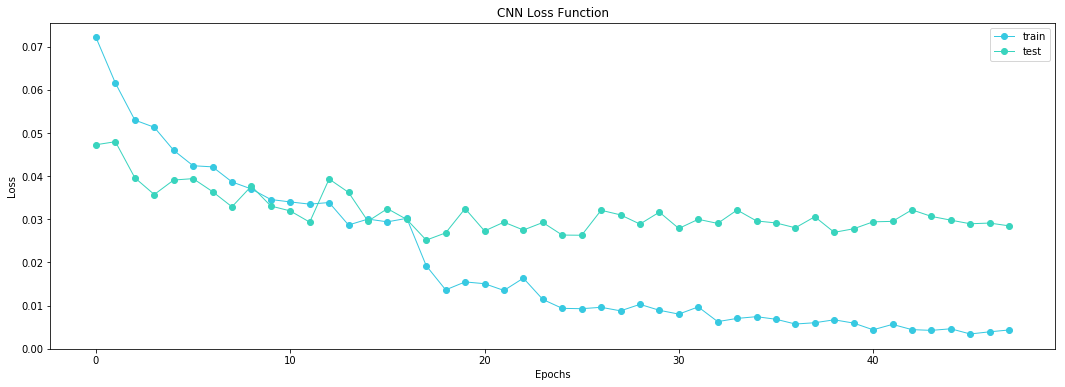

In [24]:
plt.figure(figsize=(18, 6))
plt.plot(fit_cnn.history['loss'][2:], '-o', c='#37c9e1', lw=1, label = 'train')
plt.plot(fit_cnn.history['val_loss'][2:], '-o', c='#39d4be', lw=1, label = 'test')
plt.legend()
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('CNN Loss Function');

In [25]:
cnn_mc_model.load_weights('weights.best3.cnn_mc.digits.hdf5')
cnn_scores = cnn_mc_model.evaluate(X_test.reshape(-1, 28, 28, 1), y_test, verbose=0)

print("CNN Scores: " , (cnn_scores))
print("CNN Error: %.2f%%" % (100 - cnn_scores[1]*100))
print(cnn_mc_model.summary())

CNN Scores:  [0.02090995236031068, 0.9935714285714285]
CNN Error: 0.64%
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 28, 28, 1)         0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 28, 28, 1)         4         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 28, 28, 28)        728       
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 28, 28, 28)        0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 14, 14, 28)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 14, 14, 28)        0         
_________________________________________________________________
conv

In [26]:
data_generator = ImageDataGenerator(zoom_range=0.2, 
                                    shear_range=0.2, 
                                    rotation_range=20,
                                    width_shift_range=0.2,
                                    height_shift_range=0.2)

fit_dg_cnn = cnn_mc_model.fit_generator(data_generator.flow(X_train.reshape(-1, 28, 28, 1), 
                                                            y_train, 
                                                            batch_size=128),
                                        steps_per_epoch = 1000, epochs = 50, verbose=2,
                                        validation_data = (X_valid.reshape(-1, 28, 28, 1), y_valid), 
                                        callbacks=[cnn_checkpointer, cnn_lr_reduction])

Epoch 1/50
 - 103s - loss: 0.1688 - acc: 0.9474 - val_loss: 0.0274 - val_acc: 0.9943

Epoch 00001: val_loss did not improve from 0.02517
Epoch 2/50
 - 146s - loss: 0.1335 - acc: 0.9580 - val_loss: 0.0277 - val_acc: 0.9945

Epoch 00002: val_loss did not improve from 0.02517
Epoch 3/50
 - 194s - loss: 0.1225 - acc: 0.9618 - val_loss: 0.0284 - val_acc: 0.9936

Epoch 00003: val_loss did not improve from 0.02517
Epoch 4/50
 - 223s - loss: 0.1124 - acc: 0.9646 - val_loss: 0.0282 - val_acc: 0.9931

Epoch 00004: val_loss did not improve from 0.02517
Epoch 5/50
 - 222s - loss: 0.1058 - acc: 0.9661 - val_loss: 0.0287 - val_acc: 0.9933

Epoch 00005: val_loss did not improve from 0.02517
Epoch 6/50
 - 223s - loss: 0.1025 - acc: 0.9676 - val_loss: 0.0279 - val_acc: 0.9933

Epoch 00006: val_loss did not improve from 0.02517
Epoch 7/50
 - 224s - loss: 0.0953 - acc: 0.9695 - val_loss: 0.0271 - val_acc: 0.9938

Epoch 00007: val_loss did not improve from 0.02517

Epoch 00007: ReduceLROnPlateau reducing 

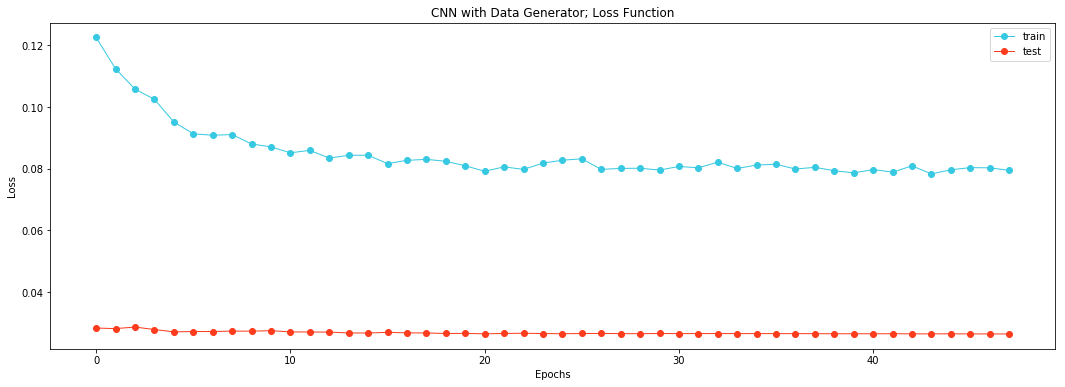

In [27]:
plt.figure(figsize=(18, 6))
plt.plot(fit_dg_cnn.history['loss'][2:], '-o', c='#37c9e1', lw=1, label = 'train')
plt.plot(fit_dg_cnn.history['val_loss'][2:], '-o', c='#fc3c1c', lw=1, label = 'test')
plt.legend()
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('CNN with Data Generator; Loss Function');

In [28]:
cnn_mc_model.load_weights('weights.best3.cnn_mc.digits.hdf5')
cnn_scores = cnn_mc_model.evaluate(X_test.reshape(-1, 28, 28, 1), y_test, verbose=0)

print("CNN with Data Generator; Scores: " , (cnn_scores))
print("CNN with Data Generator; Error: %.2f%%" % (100 - cnn_scores[1]*100))

CNN with Data Generator; Scores:  [0.02090995236031068, 0.9935714285714285]
CNN with Data Generator; Error: 0.64%


In [29]:
cnn_mc_model.save('kaggle_digits_cnn_mc_model3.h5')

In [30]:
#MLP

def mlp_mc_model():
    model = Sequential()

    model.add(Dense(1568, activation='relu', input_shape = X_train.shape[1:]))
    model.add(Dropout(0.2))
    
    model.add(Dense(392, activation='relu'))
    model.add(Dropout(0.2))
    
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(0.2))
    
    model.add(Dense(10, activation='softmax'))

    model.compile(optimizer='nadam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model

mlp_mc_model = mlp_mc_model()

In [31]:
mlp_checkpointer = ModelCheckpoint(filepath='weights.best.mlp_mc.digits.hdf5', 
                                   verbose=2, save_best_only=True)
fit_mlp = mlp_mc_model.fit(X_train, y_train, validation_data=(X_valid, y_valid), 
                           epochs=15, batch_size=128, verbose=2, callbacks=[mlp_checkpointer]);

Train on 33600 samples, validate on 4200 samples
Epoch 1/15
 - 26s - loss: 0.3132 - acc: 0.9011 - val_loss: 0.1475 - val_acc: 0.9562

Epoch 00001: val_loss improved from inf to 0.14750, saving model to weights.best.mlp_mc.digits.hdf5
Epoch 2/15
 - 24s - loss: 0.1289 - acc: 0.9606 - val_loss: 0.1353 - val_acc: 0.9574

Epoch 00002: val_loss improved from 0.14750 to 0.13532, saving model to weights.best.mlp_mc.digits.hdf5
Epoch 3/15
 - 24s - loss: 0.0919 - acc: 0.9717 - val_loss: 0.1102 - val_acc: 0.9655

Epoch 00003: val_loss improved from 0.13532 to 0.11025, saving model to weights.best.mlp_mc.digits.hdf5
Epoch 4/15
 - 24s - loss: 0.0767 - acc: 0.9771 - val_loss: 0.1037 - val_acc: 0.9738

Epoch 00004: val_loss improved from 0.11025 to 0.10368, saving model to weights.best.mlp_mc.digits.hdf5
Epoch 5/15
 - 24s - loss: 0.0620 - acc: 0.9807 - val_loss: 0.1361 - val_acc: 0.9693

Epoch 00005: val_loss did not improve from 0.10368
Epoch 6/15
 - 24s - loss: 0.0565 - acc: 0.9824 - val_loss: 0.11

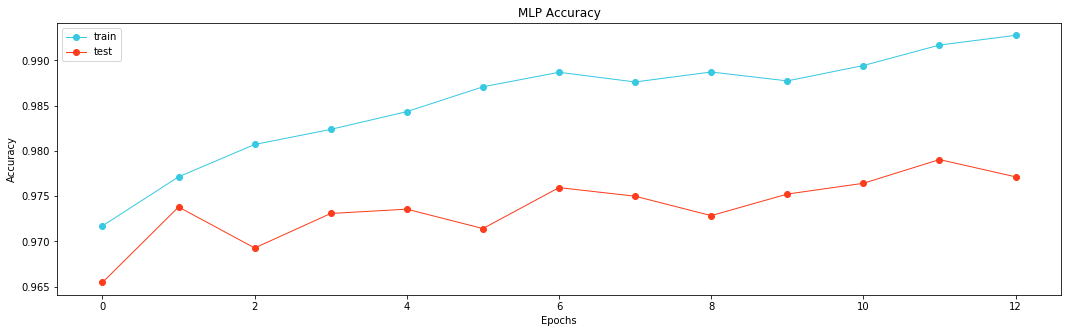

In [32]:
plt.figure(figsize=(18,5))
plt.plot(fit_mlp.history['acc'][2:], '-o', c='#37c9e1', lw=1, label = 'train')
plt.plot(fit_mlp.history['val_acc'][2:], '-o', c='#fc3c1c', lw=1, label = 'test')
plt.legend()
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('MLP Accuracy');

In [33]:
mlp_mc_model.load_weights('weights.best.mlp_mc.digits.hdf5')
mlp_scores = mlp_mc_model.evaluate(X_test, y_test)

print("\nMLP Scores: ", (mlp_scores))
print("MLP Error: %.2f%%" % (100 - mlp_scores[1] * 100))
print(mlp_mc_model.summary())

4200/4200 [==============================] - 1s 208us/step

MLP Scores:  [0.07979840929162622, 0.9802380952380952]
MLP Error: 1.98%
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_3 (Dense)              (None, 1568)              1230880   
_________________________________________________________________
dropout_4 (Dropout)          (None, 1568)              0         
_________________________________________________________________
dense_4 (Dense)              (None, 392)               615048    
_________________________________________________________________
dropout_5 (Dropout)          (None, 392)               0         
_________________________________________________________________
dense_5 (Dense)              (None, 128)               50304     
_________________________________________________________________
dropout_6 (Dropout)          (None, 128)               0         
__________

In [34]:
mlp_mc_model.save('kaggle_digits_mlp_mc_model.h5')

In [35]:
#RNN

def rnn_mc_model():
    model = Sequential()

    model.add(LSTM(196, return_sequences=True, input_shape=(1, 784)))    
    model.add(LSTM(196, return_sequences=True))
    
    model.add(LSTM(784))  
    
    model.add(Dense(10, activation='softmax'))

    model.compile(loss='categorical_crossentropy', optimizer='nadam', metrics=['accuracy'])    
    return model

In [36]:
rnn_mc_model = rnn_mc_model()
rnn_checkpointer = ModelCheckpoint(filepath='weights.best.rnn_mc.digits.hdf5', 
                                   verbose=2, save_best_only=True)
fit_rnn = rnn_mc_model.fit(X_train.reshape(X_train.shape[0], 1, X_train.shape[1]), y_train, 
                           epochs=10, batch_size=128, verbose=2, callbacks=[rnn_checkpointer],
                           validation_data=(X_valid.reshape(X_valid.shape[0], 1, X_valid.shape[1]), y_valid))

Train on 33600 samples, validate on 4200 samples
Epoch 1/10
 - 77s - loss: 0.3547 - acc: 0.8920 - val_loss: 0.1906 - val_acc: 0.9398

Epoch 00001: val_loss improved from inf to 0.19063, saving model to weights.best.rnn_mc.digits.hdf5
Epoch 2/10
 - 68s - loss: 0.1188 - acc: 0.9629 - val_loss: 0.1196 - val_acc: 0.9590

Epoch 00002: val_loss improved from 0.19063 to 0.11963, saving model to weights.best.rnn_mc.digits.hdf5
Epoch 3/10
 - 68s - loss: 0.0736 - acc: 0.9766 - val_loss: 0.1379 - val_acc: 0.9590

Epoch 00003: val_loss did not improve from 0.11963
Epoch 4/10
 - 68s - loss: 0.0521 - acc: 0.9831 - val_loss: 0.0994 - val_acc: 0.9712

Epoch 00004: val_loss improved from 0.11963 to 0.09942, saving model to weights.best.rnn_mc.digits.hdf5
Epoch 5/10
 - 68s - loss: 0.0366 - acc: 0.9880 - val_loss: 0.0990 - val_acc: 0.9721

Epoch 00005: val_loss improved from 0.09942 to 0.09896, saving model to weights.best.rnn_mc.digits.hdf5
Epoch 6/10
 - 68s - loss: 0.0281 - acc: 0.9908 - val_loss: 0.12

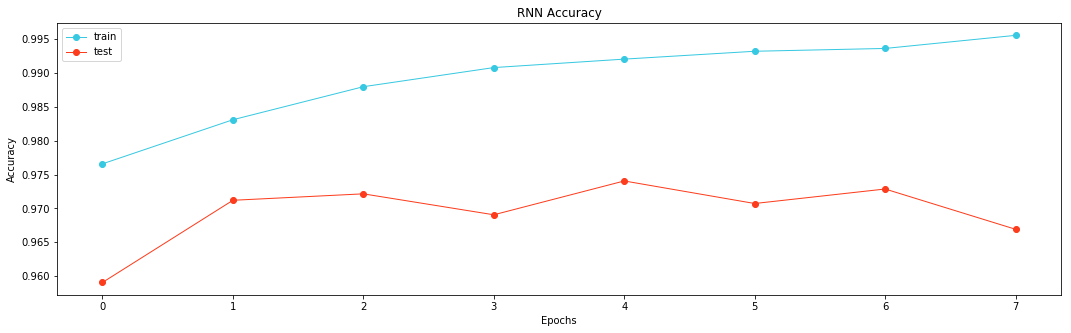

In [37]:
plt.figure(figsize=(18,5))
plt.plot(fit_rnn.history['acc'][2:], '-o', c='#37c9e1', lw=1, label = 'train')
plt.plot(fit_rnn.history['val_acc'][2:], '-o', c='#fc3c1c', lw=1, label = 'test')
plt.legend()
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('RNN Accuracy');

In [38]:
rnn_mc_model.load_weights('weights.best.rnn_mc.digits.hdf5')
rnn_scores = rnn_mc_model.evaluate(X_test.reshape(X_test.shape[0], 1, X_test.shape[1]), y_test)

print("\nRNN Scores: ", (rnn_scores))
print("RNN Error: %.2f%%" % (100 - rnn_scores[1] * 100))
print(rnn_mc_model.summary())

4200/4200 [==============================] - 2s 401us/step

RNN Scores:  [0.08174537899482641, 0.9759523809523809]
RNN Error: 2.40%
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 1, 196)            769104    
_________________________________________________________________
lstm_2 (LSTM)                (None, 1, 196)            308112    
_________________________________________________________________
lstm_3 (LSTM)                (None, 784)               3076416   
_________________________________________________________________
dense_7 (Dense)              (None, 10)                7850      
Total params: 4,161,482
Trainable params: 4,161,482
Non-trainable params: 0
_________________________________________________________________
None


In [39]:
rnn_mc_model.save('kaggle_digits_rnn_mc_model.h5')

In [40]:
#MLP SCIKIT


clf = MLPClassifier(hidden_layer_sizes=(784,), max_iter=50, alpha=1e-4,
                     solver='adam', verbose=1, tol=1e-6, random_state=1,
                     learning_rate_init=7e-4, batch_size=128)
clf.fit(X_train, y_train);

Iteration 1, loss = 0.94199239
Iteration 2, loss = 0.39940536
Iteration 3, loss = 0.28687496
Iteration 4, loss = 0.21918048
Iteration 5, loss = 0.17572250
Iteration 6, loss = 0.14371476
Iteration 7, loss = 0.12046376
Iteration 8, loss = 0.09842449
Iteration 9, loss = 0.08393928
Iteration 10, loss = 0.06942472
Iteration 11, loss = 0.05818991
Iteration 12, loss = 0.04891394
Iteration 13, loss = 0.04022566
Iteration 14, loss = 0.03228278
Iteration 15, loss = 0.02650230
Iteration 16, loss = 0.02270213
Iteration 17, loss = 0.01839325
Iteration 18, loss = 0.01557433
Iteration 19, loss = 0.01298431
Iteration 20, loss = 0.01104639
Iteration 21, loss = 0.00935877
Iteration 22, loss = 0.00781761
Iteration 23, loss = 0.00692035
Iteration 24, loss = 0.00637705
Iteration 25, loss = 0.00556056
Iteration 26, loss = 0.00453490
Iteration 27, loss = 0.00392471
Iteration 28, loss = 0.00361463
Iteration 29, loss = 0.00333566
Iteration 30, loss = 0.00362815
Iteration 31, loss = 0.03055836
Iteration 32, los

In [41]:
print("MNIST. MLPClassifier. Train score: %f" % (clf.score(X_train, y_train)*100),'%')
print("MNIST. MLPClassifier. Test score: %f" % (clf.score(X_test, y_test)*100),'%')

MNIST. MLPClassifier. Train score: 100.000000 %
MNIST. MLPClassifier. Test score: 97.071429 %


In [42]:
clf2 = MLPClassifier(hidden_layer_sizes=(784,), max_iter=50, alpha=1e-4,
                     solver='lbfgs', verbose=1, tol=1e-6, random_state=1,
                     learning_rate_init=7e-4, batch_size=128)
clf2.fit(X_train, y_train_num);

In [43]:
print("MNIST. MLPClassifier. Train score: %f" % (clf2.score(X_train, y_train_num)*100),'%')
print("MNIST. MLPClassifier. Test score: %f" % (clf2.score(X_test, y_test_num)*100),'%')

MNIST. MLPClassifier. Train score: 97.818452 %
MNIST. MLPClassifier. Test score: 97.047619 %


In [44]:
#Classifier

classifier_list = []
classifier_names = []
clf_datasets = []

acc_train, acc_test = [], []
loss_train, loss_test = [], []

In [45]:
def classifier_fit_score(classifier, classifier_name, clf_dataset, x_train, x_test, y_train, y_test):
    classifier_list.append(str(classifier))
    classifier_names.append(str(classifier_name))
    clf_datasets.append(str(clf_dataset))
    
    clf = classifier
    clf.fit(x_train, y_train)
    
    y_clf_train = clf.predict(x_train)
    y_clf_test = clf.predict(x_test)
        
    acc_clf_train = round(metrics.accuracy_score(y_train, y_clf_train), 4)
    acc_train.append(acc_clf_train)
    acc_clf_test = round(metrics.accuracy_score(y_test, y_clf_test), 4)
    acc_test.append(acc_clf_test)
    
    loss_clf_train = round(metrics.hamming_loss(y_train, y_clf_train), 4)
    loss_train.append(loss_clf_train)
    loss_clf_test = round(metrics.hamming_loss(y_test, y_clf_test), 4)
    loss_test.append(loss_clf_test)
    
    return [y_clf_train, y_clf_test, acc_clf_train, acc_clf_test, loss_clf_train, loss_clf_test]

In [46]:
def get_classifier_results():
    df_results = pd.DataFrame({'classifier' : classifier_list,
                               'classifier_name': classifier_names,
                               'clf_dataset': clf_datasets,
                               'acc_train': acc_train, 
                               'acc_test': acc_test,
                               'loss_train': loss_train, 
                               'loss_test': loss_test})
    
    df_list = ['classifier_name', 'acc_train', 'acc_test', 'loss_train', 'loss_test']
               
    return df_results, df_results[df_list]

In [47]:
clf1 = neighbors.KNeighborsClassifier()
clf2 = linear_model.LogisticRegressionCV() 
clf3 = ensemble.GradientBoostingClassifier()

In [48]:
y_knc_train, y_knc_test = classifier_fit_score(clf1, 'KNeighborsClassifier', 'digits',
                                               X_train, X_test, y_train_num, y_test_num)[:2]

In [49]:
y_lrcvc_train, y_lrcvc_test = classifier_fit_score(clf2, 'LogisticRegressionCV', 'digits',
                                                   X_train, X_test, y_train_num, y_test_num)[:2]

In [50]:
y_gbc_train, y_gbc_test = classifier_fit_score(clf3, 'GradientBoostingClassifier', 'digits',
                                               X_train, X_test, y_train_num, y_test_num)[:2]

In [51]:
df_results, df_results2  = get_classifier_results()
df_results2.sort_values('acc_test', ascending=False)

,classifier_name,acc_train,acc_test,loss_train,loss_test
0,KNeighborsClassifier,0.9778,0.9683,0.0222,0.0317
2,GradientBoostingClassifier,0.9676,0.9471,0.0324,0.0529
1,LogisticRegressionCV,0.9281,0.9181,0.0719,0.0819


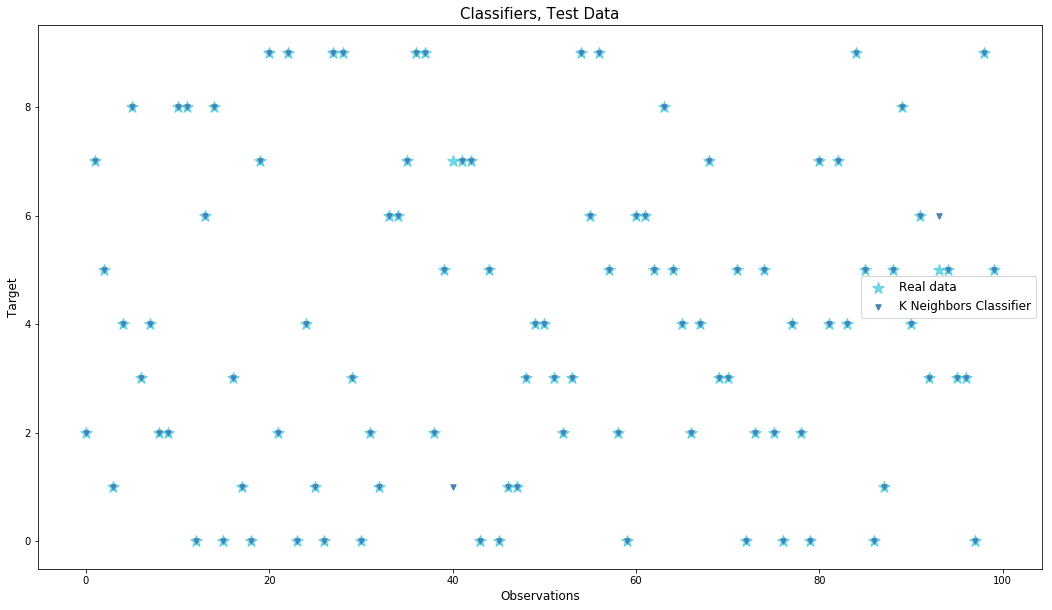

In [52]:
plt.figure(figsize=(18, 10))
n=100
x=range(n)

plt.scatter(x, y_test_num[:n], marker='*', s=150, color='#37c9e1', alpha=0.7, label='Real data')

plt.scatter(x, y_knc_test[:n], marker='v', s=30, color='steelblue', label='K Neighbors Classifier')
# plt.scatter(x, y_lrcvc_test[:n], marker='s', s=30, color='darkblue', label='Logistic RegressionCV')
# plt.scatter(x, y_gbc_test[:n], marker='o', s=30, color='darkgreen', label='GradientBoostingClassifier')

plt.xlabel('Observations', fontsize=12)
plt.ylabel('Target', fontsize=12)
plt.title('Classifiers, Test Data', fontsize=15)
plt.legend(loc=5, fontsize=12);

In [55]:
#Application

vgg16_base_model = VGG16(weights='imagenet', include_top=False)
X_train_bn = vgg16_base_model.predict(X_train_app)
X_test_bn = vgg16_base_model.predict(X_test_app)

58892288/58889256 [==============================] - 443s 8us/step


In [56]:
X_train_bn.shape

(33600, 1, 1, 512)

In [57]:
np.save('X_train_bn.npy', X_train_bn.reshape(X_train_bn.shape[0], X_train_bn.shape[3]))
np.save('X_test_bn.npy', X_test_bn.reshape(X_test_bn.shape[0], X_test_bn.shape[3]))

In [58]:
X_train_bn = np.load('X_train_bn.npy')
X_test_bn = np.load('X_test_bn.npy')
X_train_bn = X_train_bn.reshape(X_train_bn.shape[0], 1, 1, X_train_bn.shape[1])
X_test_bn = X_test_bn.reshape(X_test_bn.shape[0], 1, 1, X_test_bn.shape[1])

In [59]:
def vgg16_add_model():
    model = Sequential()
    model.add(GlobalMaxPooling2D(input_shape=X_train_bn.shape[1:]))

    model.add(Dense(4096, activation='relu'))
    model.add(Dropout(0.25))
        
    model.add(Dense(512, activation='relu'))
    model.add(Dropout(0.25))
    
    model.add(Dense(10, activation='softmax'))
    
    model.compile(loss='categorical_crossentropy', optimizer='nadam', metrics=['accuracy'])
    return model

In [60]:
vgg16_add_model = vgg16_add_model()
vgg16_checkpointer = ModelCheckpoint(filepath='weights.best.vgg16.digits.hdf5', 
                                     verbose=2, save_best_only=True)

In [61]:
vgg16_add_history = vgg16_add_model.fit(X_train_bn, y_train, 
                                        validation_data=(X_test_bn, y_test),
                                        epochs=50, batch_size=128, 
                                        callbacks=[vgg16_checkpointer], verbose=0);


Epoch 00001: val_loss improved from inf to 1.52915, saving model to weights.best.vgg16.digits.hdf5

Epoch 00002: val_loss improved from 1.52915 to 1.33722, saving model to weights.best.vgg16.digits.hdf5

Epoch 00003: val_loss improved from 1.33722 to 1.24157, saving model to weights.best.vgg16.digits.hdf5

Epoch 00004: val_loss improved from 1.24157 to 1.13666, saving model to weights.best.vgg16.digits.hdf5

Epoch 00005: val_loss improved from 1.13666 to 1.13521, saving model to weights.best.vgg16.digits.hdf5

Epoch 00006: val_loss did not improve from 1.13521

Epoch 00007: val_loss improved from 1.13521 to 1.07912, saving model to weights.best.vgg16.digits.hdf5

Epoch 00008: val_loss improved from 1.07912 to 1.05801, saving model to weights.best.vgg16.digits.hdf5

Epoch 00009: val_loss did not improve from 1.05801

Epoch 00010: val_loss did not improve from 1.05801

Epoch 00011: val_loss did not improve from 1.05801

Epoch 00012: val_loss did not improve from 1.05801

Epoch 00013: va

In [65]:
vgg16_add_model.load_weights('weights.best.vgg16.digits.hdf5')
vgg16_test_scores = vgg16_add_model.evaluate(X_test_bn, y_test)
print("Accuracy: %.2f%%" % (vgg16_test_scores[1]*100))

4200/4200 [==============================] - 1s 120us/step
Accuracy: 70.50%


In [66]:
# results

predict_labels_cnn = cnn_mc_model.predict(test_images.reshape(28000,28,28,1))
predict_labels_cnn = predict_labels_cnn.argmax(axis=-1)
predict_labels_cnn[:100]

array([2, 0, 9, 0, 3, 7, 0, 3, 0, 3, 5, 7, 4, 0, 4, 3, 3, 1, 9, 0, 9, 1,
       1, 5, 7, 4, 2, 7, 4, 7, 7, 5, 4, 2, 6, 2, 5, 5, 1, 6, 7, 7, 4, 9,
       8, 7, 8, 2, 6, 7, 6, 8, 8, 3, 8, 2, 1, 2, 2, 0, 4, 1, 7, 0, 0, 0,
       1, 9, 0, 1, 6, 5, 8, 8, 2, 8, 9, 9, 2, 3, 5, 4, 1, 0, 9, 2, 4, 3,
       6, 7, 2, 0, 6, 6, 1, 4, 3, 9, 7, 4], dtype=int64)

In [67]:
predict_labels_mlp = mlp_mc_model.predict_classes(test_images)
predict_labels_mlp[:100]

array([2, 0, 9, 9, 3, 7, 0, 3, 0, 3, 5, 7, 4, 0, 4, 3, 3, 1, 9, 0, 9, 1,
       1, 5, 7, 4, 2, 7, 4, 7, 7, 5, 4, 2, 6, 2, 5, 5, 1, 6, 7, 7, 4, 9,
       8, 7, 8, 2, 6, 7, 6, 8, 8, 3, 8, 2, 1, 2, 2, 0, 4, 1, 7, 0, 0, 0,
       1, 9, 0, 1, 6, 5, 8, 8, 2, 8, 5, 9, 2, 3, 5, 9, 1, 0, 9, 2, 4, 3,
       6, 7, 2, 0, 6, 6, 1, 4, 3, 9, 7, 4], dtype=int64)

In [68]:
predict_labels_rnn = rnn_mc_model.predict_classes(test_images.reshape(28000,1,784))
predict_labels_rnn[:100]

array([2, 0, 9, 9, 3, 7, 0, 3, 0, 3, 5, 7, 4, 0, 4, 3, 3, 1, 9, 0, 9, 1,
       1, 5, 7, 4, 2, 7, 4, 7, 7, 5, 4, 2, 6, 2, 5, 5, 1, 6, 7, 7, 4, 9,
       8, 7, 8, 2, 6, 7, 6, 8, 8, 3, 8, 2, 1, 2, 2, 0, 4, 1, 7, 0, 0, 0,
       1, 9, 0, 1, 6, 5, 8, 8, 2, 8, 9, 9, 2, 3, 5, 9, 1, 0, 9, 2, 4, 3,
       6, 7, 2, 0, 6, 6, 1, 4, 3, 9, 7, 4], dtype=int64)

In [69]:
predict_labels_mlpc = clf.predict(test_images)
predict_labels_mlpc_num = np.array([np.argmax(x) for x in predict_labels_mlpc])
predict_labels_mlpc_num[:100]

array([2, 0, 9, 9, 3, 0, 0, 3, 0, 3, 5, 7, 4, 0, 4, 3, 3, 1, 9, 0, 9, 1,
       1, 5, 7, 4, 2, 7, 4, 7, 7, 5, 4, 2, 6, 2, 5, 5, 1, 6, 7, 7, 4, 9,
       8, 7, 8, 2, 6, 7, 6, 8, 8, 3, 8, 2, 1, 2, 2, 0, 4, 1, 7, 0, 0, 0,
       1, 9, 0, 1, 6, 5, 8, 8, 2, 8, 8, 9, 2, 3, 5, 9, 1, 0, 9, 2, 4, 3,
       6, 7, 2, 0, 6, 6, 1, 4, 3, 9, 7, 4], dtype=int64)

In [70]:
submission_cnn = pd.DataFrame({"ImageId": range(1, len(predict_labels_cnn)+1), 
                               "Label": predict_labels_cnn})
print(submission_cnn[0:20])
submission_cnn.to_csv('kaggle_digits_cnn_mc_model.csv', index=False)

    ImageId  Label
0         1      2
1         2      0
2         3      9
3         4      0
4         5      3
5         6      7
6         7      0
7         8      3
8         9      0
9        10      3
10       11      5
11       12      7
12       13      4
13       14      0
14       15      4
15       16      3
16       17      3
17       18      1
18       19      9
19       20      0


In [71]:
submission_mlp = pd.DataFrame({"ImageId": range(1, len(predict_labels_mlp)+1), 
                               "Label": predict_labels_mlp})
print(submission_mlp[:20])
submission_mlp.to_csv('kaggle_digits_mlp_mc_model.csv', index=False)

    ImageId  Label
0         1      2
1         2      0
2         3      9
3         4      9
4         5      3
5         6      7
6         7      0
7         8      3
8         9      0
9        10      3
10       11      5
11       12      7
12       13      4
13       14      0
14       15      4
15       16      3
16       17      3
17       18      1
18       19      9
19       20      0


In [72]:
submission_rnn = pd.DataFrame({"ImageId": range(1, len(predict_labels_rnn)+1), 
                               "Label": predict_labels_rnn})
print(submission_rnn[0:20])
submission_rnn.to_csv('kaggle_digits_rnn_mc_model.csv', index=False)

    ImageId  Label
0         1      2
1         2      0
2         3      9
3         4      9
4         5      3
5         6      7
6         7      0
7         8      3
8         9      0
9        10      3
10       11      5
11       12      7
12       13      4
13       14      0
14       15      4
15       16      3
16       17      3
17       18      1
18       19      9
19       20      0


In [73]:
submission_mlpc = pd.DataFrame({"ImageId": range(1, len(predict_labels_mlpc_num)+1), 
                                "Label": predict_labels_mlpc_num})
print(submission_mlpc[0:20])
submission_mlpc.to_csv('kaggle_digits_mlpc_model.csv', index=False)

    ImageId  Label
0         1      2
1         2      0
2         3      9
3         4      9
4         5      3
5         6      0
6         7      0
7         8      3
8         9      0
9        10      3
10       11      5
11       12      7
12       13      4
13       14      0
14       15      4
15       16      3
16       17      3
17       18      1
18       19      9
19       20      0


In [74]:
real_data = np.array([2, 0, 9, 0, 3, 7, 0, 3, 0, 3,
                      5, 7, 4, 0, 4, 3, 3, 1, 9, 0,
                      9, 1, 1, 5, 7, 4, 2, 7, 4, 7,
                      7, 5, 4, 2, 6, 2, 5, 5, 1, 6,
                      7, 7, 4, 9, 8, 7, 8, 2, 6, 7,
                      6, 8, 8, 3, 8, 2, 1, 2, 2, 0,
                      4, 1, 7, 0, 0, 0, 1, 9, 0, 1,
                      6, 5, 8, 8, 2, 8, 9, 9, 2, 3,
                      5, 4, 1, 0, 9, 2, 4, 3, 6, 7,
                      2, 0, 6, 6, 1, 4, 3, 9, 7, 4,
                      0, 9, 2, 0, 7, 3, 0, 5, 0, 8,
                      0, 0, 4, 7, 1, 7, 1, 1, 3, 3,
                      3, 7, 2, 8, 6, 3, 8, 7, 7, 4,
                      3, 5, 4, 0, 0, 0, 3, 1, 3, 6,
                      4, 3, 4, 5, 5, 8, 7, 4, 2, 8,
                      4, 3, 5, 6, 5, 3, 7, 5, 7, 8,
                      3, 0, 4, 5, 1, 3, 7, 6, 3, 0,
                      2, 7, 8, 6, 1, 3, 7, 4, 1, 2,
                      4, 8, 5, 2, 4, 9, 2, 1, 6, 0,
                      6, 1, 4, 9, 6, 0, 9, 7, 6, 9,
                      1, 9, 0, 9, 9, 0, 8, 4, 6, 2,
                      0, 9, 3, 6, 3, 2, 1, 6, 3, 4,
                      2, 3, 1, 2, 2, 0, 4, 6, 1, 0,
                      0, 4, 9, 1, 7, 3, 2, 3, 8, 6,
                      8, 6, 2, 8, 5, 5, 4, 8, 3, 5,
                      9, 7, 1, 3, 8, 4, 5, 1, 4, 5,
                      6, 3, 3, 5, 7, 0, 6, 8, 3, 1,
                      6, 0, 6, 3, 9, 5, 1, 5, 8, 4,
                      0, 9, 2, 0, 5, 3, 7, 1, 9, 9,
                      5, 7, 7, 9, 9, 6, 3, 0, 3, 3])

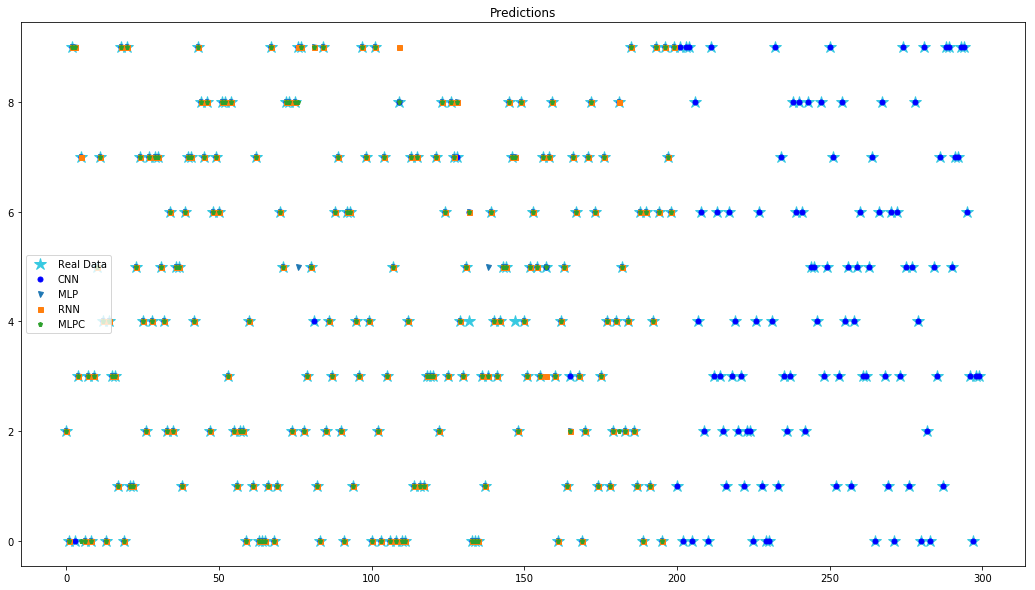

In [75]:
plt.figure(figsize = (18, 10))

plt.plot(real_data[0:300], '*', ms=12, c='#37c9e1', label='Real Data')

plt.plot(submission_cnn['Label'][0:300], 'bo', ms=5, label='CNN')
plt.plot(submission_mlp['Label'][0:200], 'v', ms=5, label='MLP')
plt.plot(submission_rnn['Label'][0:200], 's', ms=5, label='RNN')
plt.plot(submission_mlpc['Label'][0:200], 'p', ms=5, label='MLPC')

plt.legend(loc=6)
plt.title("Predictions");

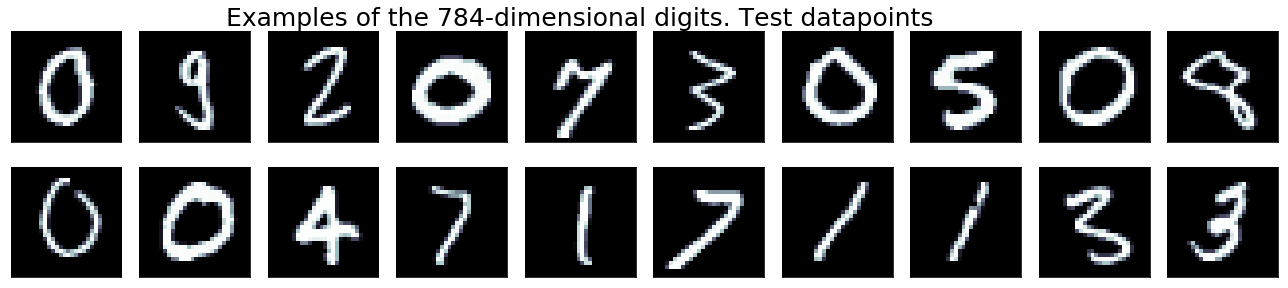

In [76]:
fig, ax = plt.subplots(figsize=(18, 4), nrows=2, ncols=10, sharex=True, sharey=True,)
ax = ax.flatten()
for i in range(20):
    image = test_images[100:120][i].reshape(28,28)
    ax[i].imshow(image, cmap=cm.bone)

ax[0].set_xticks([])
ax[0].set_yticks([])
plt.tight_layout()
plt.gcf()
ax[4].set_title('Examples of the 784-dimensional digits. Test datapoints', fontsize=25);